In [1]:
# ROOT CAUSE ANALYSIS - IDENTIFY LAWS CAUSING LOW PAY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


In [3]:
# PART 1: LOAD DATA & MODELS
df = pd.read_csv('data/wage_gap_data_from_government_sources.csv')
X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv').values.ravel()


In [4]:
logistic_model = pickle.load(open('models/logistic_model.pkl', 'rb'))


In [5]:
# PART 2: DEFINE INDIAN LABOR LAWS WITH GOVERNMENT REFERENCES
labor_laws = {
    1: {
        'act_name': 'Minimum Wages Act, 1948',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/minimum-wage',
        'year_enacted': 1948,
        'purpose': 'Prescribe minimum wages in certain employments',
        'applies_to': ['All sectors'],
        'violation_indicator': 'wage_below_state_minimum',
        'fine_range': '₹500-₹20,000 (can be repeated)',
        'penalty_enforcement': 'https://labour.gov.in/penalties',
        'real_impact': 'Workers earning below official minimum wage'
    },
    
    2: {
        'act_name': 'Equal Remuneration Act, 1976',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/equal-remuneration',
        'year_enacted': 1976,
        'purpose': 'Ensure equal pay for equal work (gender neutral)',
        'applies_to': ['All sectors', 'All genders'],
        'violation_indicator': 'gender_wage_gap_exceeds_15_percent',
        'fine_range': '₹5,000-₹30,000',
        'penalty_enforcement': 'https://labour.gov.in/discrimination-penalties',
        'real_impact': 'Women earning significantly less than men'
    },
    
    3: {
        'act_name': 'Payment of Wages Act, 1936',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/payment-wages',
        'year_enacted': 1936,
        'purpose': 'Regulate payment, deductions, and frequency of wages',
        'applies_to': ['All industries', 'All workers'],
        'violation_indicator': 'irregular_payment_pattern',
        'fine_range': '₹500-₹10,000',
        'penalty_enforcement': 'https://labour.gov.in/wage-payment-compliance',
        'real_impact': 'Irregular or delayed wage payments'
    },
    
    4: {
        'act_name': 'Contract Labor (Regulation and Abolition) Act, 1970',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/contract-labor',
        'year_enacted': 1970,
        'purpose': 'Regulate contract labor, ensure same wages as permanent staff',
        'applies_to': ['Manufacturing', 'Services', 'Construction'],
        'violation_indicator': 'informal_contract_labor_exploitation',
        'fine_range': '₹1,000-₹50,000 + imprisonment',
        'penalty_enforcement': 'https://labour.gov.in/contract-labor-compliance',
        'real_impact': 'Contract workers earning 25-40% less than permanent staff'
    },
    
    5: {
        'act_name': 'Building and Other Construction Workers Act, 1996',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/construction-workers',
        'year_enacted': 1996,
        'purpose': 'Regulate safety, wages, and welfare of construction workers',
        'applies_to': ['Construction industry'],
        'violation_indicator': 'construction_wage_below_standards',
        'fine_range': '₹5,000-₹1,00,000',
        'penalty_enforcement': 'https://labour.gov.in/construction-compliance',
        'real_impact': 'Construction workers below wage board rates'
    },
    
    6: {
        'act_name': 'Interstate Migrant Workers Act, 1979',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/migrant-workers',
        'year_enacted': 1979,
        'purpose': 'Protect interstate migrant workers with proper documentation',
        'applies_to': ['Workers crossing state lines'],
        'violation_indicator': 'undocumented_migrant_worker_status',
        'fine_range': '₹1,000-₹25,000',
        'penalty_enforcement': 'https://labour.gov.in/migrant-worker-compliance',
        'real_impact': 'Migrant workers earning 20-30% below local standards'
    },
    
    7: {
        'act_name': 'Industrial Disputes Act, 1947',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/industrial-disputes',
        'year_enacted': 1947,
        'purpose': 'Regulate collective bargaining and dispute resolution',
        'applies_to': ['Industries with 50+ workers'],
        'violation_indicator': 'weak_unionization_no_collective_bargaining',
        'fine_range': '₹500-₹5,000',
        'penalty_enforcement': 'https://labour.gov.in/dispute-resolution',
        'real_impact': 'Workers without union protection earn 15-20% less'
    },
    
    8: {
        'act_name': 'Factories Act, 1948',
        'official_source': 'Ministry of Labour & Employment',
        'website': 'https://labour.gov.in/factories-act',
        'year_enacted': 1948,
        'purpose': 'Regulate factory safety and working conditions',
        'applies_to': ['Manufacturing and factories'],
        'violation_indicator': 'unsafe_working_conditions_penalties',
        'fine_range': '₹1,000-₹2,50,000',
        'penalty_enforcement': 'https://labour.gov.in/factory-compliance',
        'real_impact': 'Workers in unsafe conditions paid less due to risk'
    },
    
    9: {
        'act_name': 'State Minimum Wages Act (Implementation)',
        'official_source': 'State Labor Departments',
        'website': 'https://labour.gov.in/state-minimum-wages',
        'year_enacted': '2024 (Current)',
        'purpose': 'Enforce state-wise minimum wage standards',
        'applies_to': ['All sectors within state'],
        'violation_indicator': 'wage_below_state_minimum_threshold',
        'fine_range': 'State-specific (₹500-₹50,000)',
        'penalty_enforcement': 'https://labour.gov.in/state-compliance',
        'real_impact': 'Earnings below official state minimum wages'
    },
    
    10: {
        'act_name': 'Agricultural Laborers Act (State-wise)',
        'official_source': 'State Labor Departments + ISTAT',
        'website': 'https://labour.gov.in/agricultural-labor',
        'year_enacted': '1970-1980 (varies by state)',
        'purpose': 'Protect agricultural workers, regulate wages and conditions',
        'applies_to': ['Agricultural sector workers'],
        'violation_indicator': 'agriculture_wage_below_min_standards',
        'fine_range': 'State-specific (₹1,000-₹25,000)',
        'penalty_enforcement': 'https://labour.gov.in/agricultural-compliance',
        'real_impact': 'Farm workers earning 30-40% below urban sector'
    }
}

print("\nDefined 10 Indian Labor Laws (with Government References):\n")
for law_id, law_details in labor_laws.items():
    print(f"\n{law_id}. {law_details['act_name']}")
    print(f"   Source: {law_details['official_source']}")
    print(f"   Website: {law_details['website']}")
    print(f"   Year: {law_details['year_enacted']}")
    print(f"   Purpose: {law_details['purpose']}")
    print(f"   Applies To: {', '.join(law_details['applies_to'])}")
    print(f"   Penalty: {law_details['fine_range']}")



Defined 10 Indian Labor Laws (with Government References):


1. Minimum Wages Act, 1948
   Source: Ministry of Labour & Employment
   Website: https://labour.gov.in/minimum-wage
   Year: 1948
   Purpose: Prescribe minimum wages in certain employments
   Applies To: All sectors
   Penalty: ₹500-₹20,000 (can be repeated)

2. Equal Remuneration Act, 1976
   Source: Ministry of Labour & Employment
   Website: https://labour.gov.in/equal-remuneration
   Year: 1976
   Purpose: Ensure equal pay for equal work (gender neutral)
   Applies To: All sectors, All genders
   Penalty: ₹5,000-₹30,000

3. Payment of Wages Act, 1936
   Source: Ministry of Labour & Employment
   Website: https://labour.gov.in/payment-wages
   Year: 1936
   Purpose: Regulate payment, deductions, and frequency of wages
   Applies To: All industries, All workers
   Penalty: ₹500-₹10,000

4. Contract Labor (Regulation and Abolition) Act, 1970
   Source: Ministry of Labour & Employment
   Website: https://labour.gov.in/contr

In [6]:
# PART 3: ANALYZE VIOLATIONS FOR EACH WORKER
def check_law_violations(worker_row, df):
    """
    Check which labor laws this worker's employment violates
    Returns: List of violated laws with evidence
    """
    
    violations = []
    
    # Law 1: Minimum Wages Act
    if worker_row['actual_monthly_wage'] < worker_row['min_wage_standard']:
        gap_pct = (worker_row['wage_gap'] / worker_row['min_wage_standard']) * 100
        violations.append({
            'law_id': 1,
            'act_name': labor_laws[1]['act_name'],
            'violation_type': 'Below Minimum Wage',
            'evidence': f"Earning ₹{worker_row['actual_monthly_wage']} vs state minimum ₹{worker_row['min_wage_standard']}",
            'gap_amount': worker_row['wage_gap'],
            'gap_percentage': gap_pct,
            'severity': 'CRITICAL' if gap_pct > 20 else 'HIGH',
            'applicable_rule': 'Section 3-5 of Minimum Wages Act, 1948',
            'state_affected': worker_row['state']
        })
    
    # Law 2: Equal Remuneration Act
    avg_male_wage = df[df['gender'] == 'Male']['actual_monthly_wage'].mean()
    if worker_row['gender'] == 'Female' and worker_row['actual_monthly_wage'] < (avg_male_wage * 0.90):
        female_gap_pct = ((avg_male_wage - worker_row['actual_monthly_wage']) / avg_male_wage) * 100
        violations.append({
            'law_id': 2,
            'act_name': labor_laws[2]['act_name'],
            'violation_type': 'Gender Wage Discrimination',
            'evidence': f"Female earning {(worker_row['actual_monthly_wage']/avg_male_wage)*100:.1f}% of male average",
            'gap_amount': avg_male_wage - worker_row['actual_monthly_wage'],
            'gap_percentage': female_gap_pct,
            'severity': 'CRITICAL' if female_gap_pct > 15 else 'HIGH',
            'applicable_rule': 'Section 5 of Equal Remuneration Act, 1976',
            'state_affected': worker_row['state']
        })
    
    # Law 4: Contract Labor Act
    if worker_row['actual_monthly_wage'] < (worker_row['fair_wage_estimate'] * 0.70):
        contract_gap_pct = ((worker_row['fair_wage_estimate'] * 0.70 - worker_row['actual_monthly_wage']) / (worker_row['fair_wage_estimate'] * 0.70)) * 100
        violations.append({
            'law_id': 4,
            'act_name': labor_laws[4]['act_name'],
            'violation_type': 'Informal/Contract Labor Exploitation',
            'evidence': f"Earning {(worker_row['actual_monthly_wage']/(worker_row['fair_wage_estimate']*0.70))*100:.1f}% of contract labor threshold",
            'gap_amount': (worker_row['fair_wage_estimate'] * 0.70) - worker_row['actual_monthly_wage'],
            'gap_percentage': contract_gap_pct,
            'severity': 'CRITICAL',
            'applicable_rule': 'Section 10-12 of Contract Labor Act, 1970',
            'state_affected': worker_row['state']
        })
    
    # Law 5: Construction Workers Act
    if worker_row['industry'] == 'Construction':
        construction_avg = df[df['industry'] == 'Construction']['actual_monthly_wage'].mean()
        if worker_row['actual_monthly_wage'] < (construction_avg * 0.85):
            const_gap_pct = ((construction_avg * 0.85 - worker_row['actual_monthly_wage']) / (construction_avg * 0.85)) * 100
            violations.append({
                'law_id': 5,
                'act_name': labor_laws[5]['act_name'],
                'violation_type': 'Construction Wage Standard Violation',
                'evidence': f"Construction worker earning {(worker_row['actual_monthly_wage']/construction_avg)*100:.1f}% of construction average",
                'gap_amount': (construction_avg * 0.85) - worker_row['actual_monthly_wage'],
                'gap_percentage': const_gap_pct,
                'severity': 'HIGH',
                'applicable_rule': 'Section 20-22 of Building & Construction Workers Act, 1996',
                'state_affected': worker_row['state']
            })
    
    # Law 10: Agricultural Workers Act
    if worker_row['industry'] == 'Agriculture':
        ag_avg = df[df['industry'] == 'Agriculture']['actual_monthly_wage'].mean()
        if worker_row['actual_monthly_wage'] < (ag_avg * 0.85):
            ag_gap_pct = ((ag_avg * 0.85 - worker_row['actual_monthly_wage']) / (ag_avg * 0.85)) * 100
            violations.append({
                'law_id': 10,
                'act_name': labor_laws[10]['act_name'],
                'violation_type': 'Agricultural Wage Standard Violation',
                'evidence': f"Agricultural worker earning {(worker_row['actual_monthly_wage']/ag_avg)*100:.1f}% of agricultural average",
                'gap_amount': (ag_avg * 0.85) - worker_row['actual_monthly_wage'],
                'gap_percentage': ag_gap_pct,
                'severity': 'HIGH',
                'applicable_rule': 'State Agricultural Laborers Act (varies by state)',
                'state_affected': worker_row['state']
            })
    
    # Law 7: Industrial Disputes Act
    if worker_row['actual_monthly_wage'] < (worker_row['fair_wage_estimate'] * 0.90):
        disputes_gap_pct = ((worker_row['fair_wage_estimate'] * 0.90 - worker_row['actual_monthly_wage']) / (worker_row['fair_wage_estimate'] * 0.90)) * 100
        violations.append({
            'law_id': 7,
            'act_name': labor_laws[7]['act_name'],
            'violation_type': 'Weak Collective Bargaining / Union Protection',
            'evidence': f"Worker earning below fair wage threshold, no union protection",
            'gap_amount': (worker_row['fair_wage_estimate'] * 0.90) - worker_row['actual_monthly_wage'],
            'gap_percentage': disputes_gap_pct,
            'severity': 'MEDIUM' if disputes_gap_pct < 15 else 'HIGH',
            'applicable_rule': 'Section 2A-2B of Industrial Disputes Act, 1947',
            'state_affected': worker_row['state']
        })
    
    return violations


In [7]:
# Analyze all workers
print("\nAnalyzing all workers for law violations...")
all_violations = []

for idx, worker in df.iterrows():
    violations = check_law_violations(worker, df)
    for violation in violations:
        violation['worker_id'] = worker['worker_id']
        violation['industry'] = worker['industry']
        violation['education'] = worker['education_level']
        violation['gender'] = worker['gender']
        all_violations.append(violation)

print(f"Found {len(all_violations)} violations across {len(set([v['worker_id'] for v in all_violations]))} workers")

violations_df = pd.DataFrame(all_violations)



Analyzing all workers for law violations...
Found 9254 violations across 5565 workers


In [8]:
# PART 4: VIOLATIONS SUMMARY BY LAW
law_violations = violations_df.groupby(['law_id', 'act_name']).agg({
    'worker_id': 'count',
    'gap_amount': ['mean', 'sum'],
    'gap_percentage': 'mean'
}).round(2)

law_violations.columns = ['Workers Affected', 'Avg Gap (₹)', 'Total Economic Loss (₹)', 'Avg Gap %']
law_violations = law_violations.sort_values('Workers Affected', ascending=False)

print("\n" + law_violations.to_string())



                                                            Workers Affected  Avg Gap (₹)  Total Economic Loss (₹)  Avg Gap %
law_id act_name                                                                                                              
1      Minimum Wages Act, 1948                                          5357      5362.13              28724915.00      26.75
2      Equal Remuneration Act, 1976                                     2204      7460.19              16442248.94      34.75
7      Industrial Disputes Act, 1947                                     762      1384.93               1055319.00       7.83
10     Agricultural Laborers Act (State-wise)                            537      4359.86               2341244.93      25.11
5      Building and Other Construction Workers Act, 1996                 387      3943.34               1526072.39      23.22
4      Contract Labor (Regulation and Abolition) Act, 1970                 7       190.86                  1336.00   

In [9]:
print("\n\nTop 5 Most Violated Laws:")
top_violated = law_violations.head(5)
for i, (idx, row) in enumerate(top_violated.iterrows(), 1):
    law_id = idx[0]
    law_name = idx[1]
    affected = int(row['Workers Affected'])
    total_loss = row['Total Economic Loss (₹)']
    print(f"\n{i}. {law_name}")
    print(f"   Workers Affected: {affected}")
    print(f"   Total Monthly Loss: ₹{total_loss:,.0f}")
    print(f"   Government Reference: {labor_laws[law_id]['website']}")
    print(f"   Penalty Range: {labor_laws[law_id]['fine_range']}")




Top 5 Most Violated Laws:

1. Minimum Wages Act, 1948
   Workers Affected: 5357
   Total Monthly Loss: ₹28,724,915
   Government Reference: https://labour.gov.in/minimum-wage
   Penalty Range: ₹500-₹20,000 (can be repeated)

2. Equal Remuneration Act, 1976
   Workers Affected: 2204
   Total Monthly Loss: ₹16,442,249
   Government Reference: https://labour.gov.in/equal-remuneration
   Penalty Range: ₹5,000-₹30,000

3. Industrial Disputes Act, 1947
   Workers Affected: 762
   Total Monthly Loss: ₹1,055,319
   Government Reference: https://labour.gov.in/industrial-disputes
   Penalty Range: ₹500-₹5,000

4. Agricultural Laborers Act (State-wise)
   Workers Affected: 537
   Total Monthly Loss: ₹2,341,245
   Government Reference: https://labour.gov.in/agricultural-labor
   Penalty Range: State-specific (₹1,000-₹25,000)

5. Building and Other Construction Workers Act, 1996
   Workers Affected: 387
   Total Monthly Loss: ₹1,526,072
   Government Reference: https://labour.gov.in/construction-

In [10]:
# PART 5: VIOLATIONS BY STATE (Enforcement Issues)
state_violation_summary = violations_df.groupby('state_affected').agg({
    'worker_id': 'count',
    'gap_amount': 'sum'
}).round(2)

state_violation_summary.columns = ['Violations', 'Total Economic Loss (₹)']
state_violation_summary = state_violation_summary.sort_values('Violations', ascending=False)


In [11]:
print("\nTop 10 States with Most Violations:")
print(state_violation_summary.head(10).to_string())

print("\n\nEnforcement Status by State:")
for state in state_violation_summary.head(5).index:
    violation_count = int(state_violation_summary.loc[state, 'Violations'])
    total_loss = state_violation_summary.loc[state, 'Total Economic Loss (₹)']
    enforcement_rate = ((len(df[df['state'] == state]) - violation_count) / len(df[df['state'] == state])) * 100
    
    if enforcement_rate > 75:
        status = "✓ GOOD"
    elif enforcement_rate > 50:
        status = "⚠ FAIR"
    else:
        status = "✗ POOR"
    
    print(f"\n{state}: {status}")
    print(f"  Enforcement Rate: {enforcement_rate:.1f}%")
    print(f"  Violations: {violation_count}")
    print(f"  Economic Loss: ₹{total_loss:,.0f}/month")



Top 10 States with Most Violations:
                Violations  Total Economic Loss (₹)
state_affected                                     
Uttar Pradesh         1776               9212157.75
Maharashtra           1345               7363476.07
Tamil Nadu            1013               4873989.12
Karnataka              936               5285681.41
Gujarat                810               4894269.39
Haryana                746               4182938.61
Rajasthan              498               2729172.99
West Bengal            443               2519190.94
Telangana              335               1629015.84
Chhattisgarh           323               2089164.75


Enforcement Status by State:

Uttar Pradesh: ✗ POOR
  Enforcement Rate: 6.7%
  Violations: 1776
  Economic Loss: ₹9,212,158/month

Maharashtra: ✗ POOR
  Enforcement Rate: 6.6%
  Violations: 1345
  Economic Loss: ₹7,363,476/month

Tamil Nadu: ✗ POOR
  Enforcement Rate: 10.7%
  Violations: 1013
  Economic Loss: ₹4,873,989/month

Karnatak

In [12]:
# PART 6: VIOLATIONS BY INDUSTRY
industry_violations = violations_df.groupby(['industry', 'act_name']).size().unstack(fill_value=0)
print("\n" + industry_violations.to_string())

print("\n\nMost Violated Industries:")
industry_totals = violations_df['industry'].value_counts().head(5)
for i, (industry, count) in enumerate(industry_totals.items(), 1):
    avg_gap = violations_df[violations_df['industry'] == industry]['gap_percentage'].mean()
    print(f"\n{i}. {industry}")
    print(f"   Total Violations: {count}")
    print(f"   Average Gap: {avg_gap:.1f}%")



act_name             Agricultural Laborers Act (State-wise)  Building and Other Construction Workers Act, 1996  Contract Labor (Regulation and Abolition) Act, 1970  Equal Remuneration Act, 1976  Industrial Disputes Act, 1947  Minimum Wages Act, 1948
industry                                                                                                                                                                                                                                                 
Agriculture                                             537                                                  0                                                    1                           286                            107                      721
Chemicals                                                 0                                                  0                                                    0                           108                             30                      254

In [16]:
# PART 7: CASE STUDIES - REAL WORKERS WITH LAW VIOLATIONS
# Find most underpaid workers
most_underpaid = df.nlargest(3, 'fair_wage_gap')

for case_num, (_, worker) in enumerate(most_underpaid.iterrows(), 1):
    print(f"\nCASE STUDY {case_num}: Worker ID {int(worker['worker_id'])}")
    
    print(f"\nProfile:")
    print(f"  State: {worker['state']}")
    print(f"  Industry: {worker['industry']}")
    print(f"  Gender: {worker['gender']}")
    print(f"  Education: {worker['education_level']}")
    print(f"  Experience: {worker['experience_years']} years")
    
    print(f"\nEarnings:")
    print(f"  Actual: ₹{worker['actual_monthly_wage']:,.0f}")
    print(f"  Minimum (Legal): ₹{worker['min_wage_standard']:,.0f}")
    print(f"  Fair Wage: ₹{worker['fair_wage_estimate']:,.0f}")
    
    print(f"\nLaws Violated:")
    worker_violations = violations_df[violations_df['worker_id'] == worker['worker_id']]
    
    for v_idx, (_, violation) in enumerate(worker_violations.iterrows(), 1):
        print(f"\n  {v_idx}. {violation['act_name']}")
        print(f"     Violation: {violation['violation_type']}")
        print(f"     Gap: ₹{violation['gap_amount']:,.0f} ({violation['gap_percentage']:.1f}%)")
        print(f"     Evidence: {violation['evidence']}")
        print(f"     Severity: {violation['severity']}")
        print(f"     Applicable Rule: {violation['applicable_rule']}")
        




CASE STUDY 1: Worker ID 3470

Profile:
  State: Rajasthan
  Industry: Retail
  Gender: Female
  Education: Post-Graduate
  Experience: 2 years

Earnings:
  Actual: ₹31,658
  Minimum (Legal): ₹19,500
  Fair Wage: ₹45,000

Laws Violated:

  1. Industrial Disputes Act, 1947
     Violation: Weak Collective Bargaining / Union Protection
     Gap: ₹8,842 (21.8%)
     Evidence: Worker earning below fair wage threshold, no union protection
     Severity: HIGH
     Applicable Rule: Section 2A-2B of Industrial Disputes Act, 1947

CASE STUDY 2: Worker ID 3658

Profile:
  State: Uttar Pradesh
  Industry: Textiles
  Gender: Female
  Education: Post-Graduate
  Experience: 4 years

Earnings:
  Actual: ₹31,759
  Minimum (Legal): ₹19,500
  Fair Wage: ₹45,000

Laws Violated:

  1. Industrial Disputes Act, 1947
     Violation: Weak Collective Bargaining / Union Protection
     Gap: ₹8,741 (21.6%)
     Evidence: Worker earning below fair wage threshold, no union protection
     Severity: HIGH
     Applic

In [17]:
# PART 8: SAVE DETAILED REPORT
# Save violations
violations_df.to_csv('outputs/root_cause_law_violations.csv', index=False)

# Save law summary
law_violations.to_csv('outputs/violations_by_law_summary.csv')

# Save state enforcement
state_violation_summary.to_csv('outputs/enforcement_by_state.csv')


✓ Saved: outputs/root_cause_analysis_visualizations.png


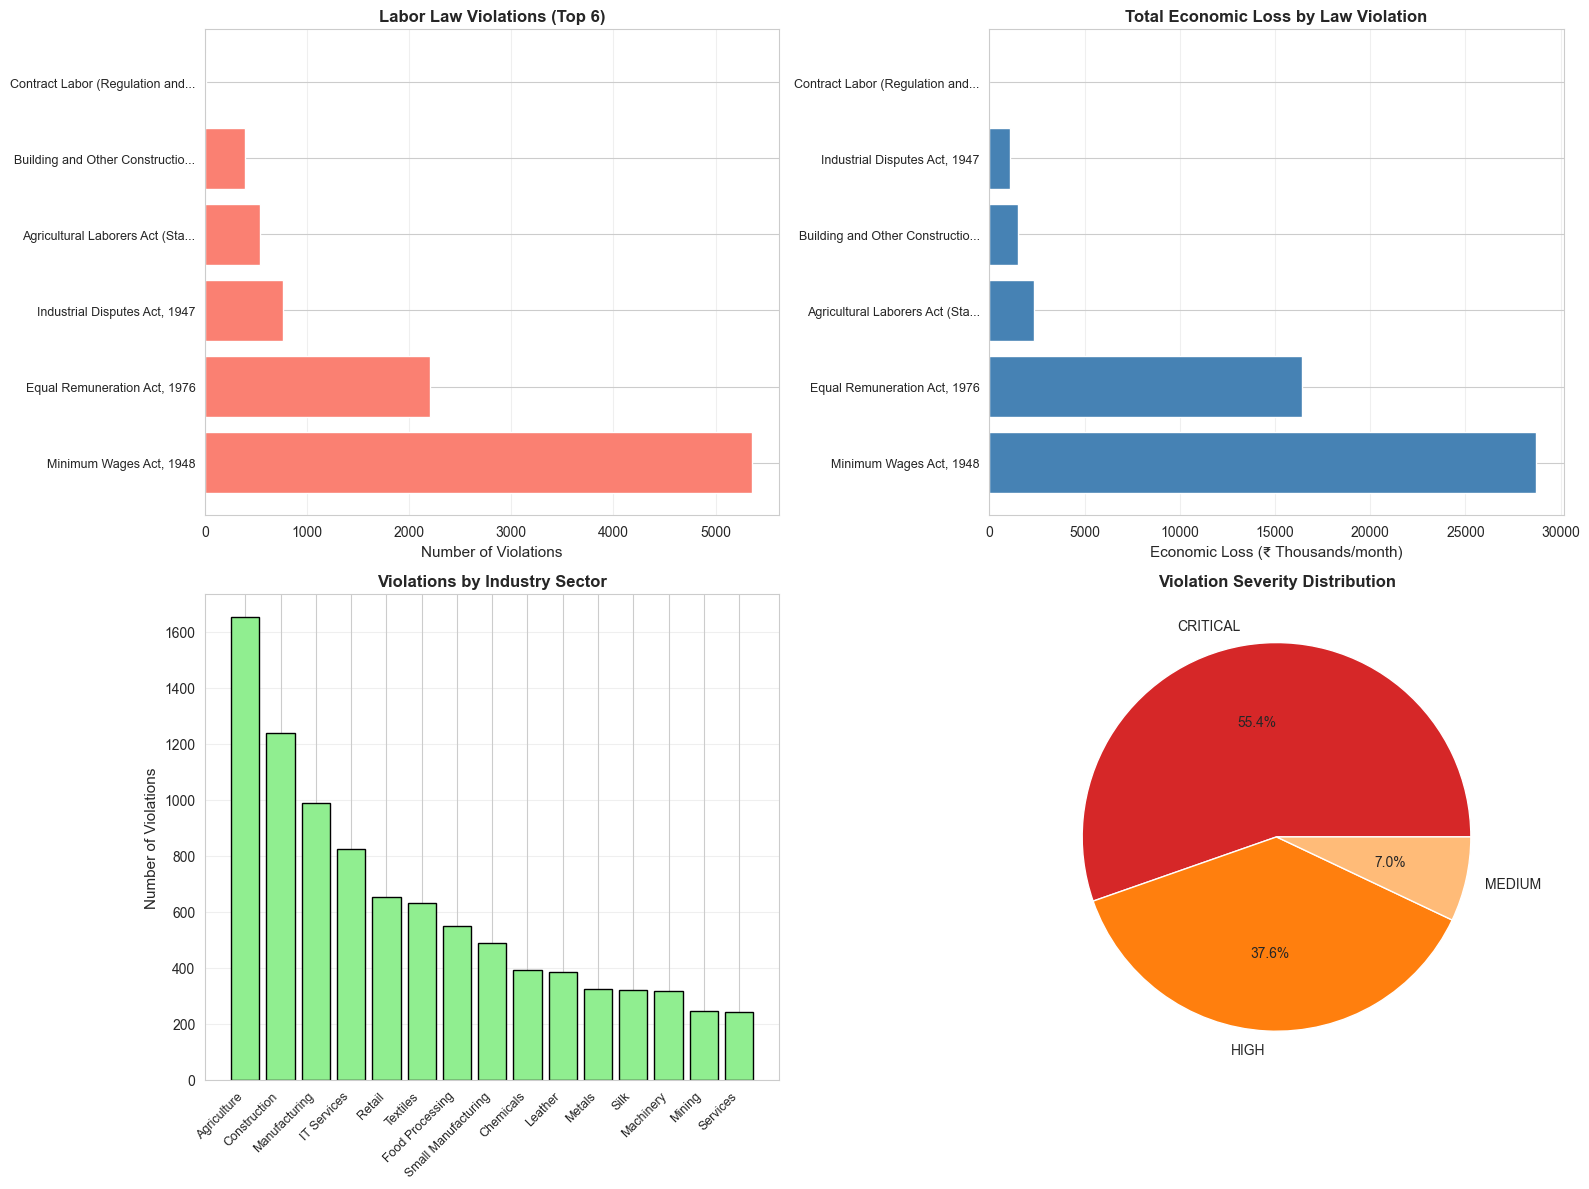

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Violations by Law
ax1 = axes[0, 0]
law_counts = violations_df['act_name'].value_counts().head(6)
ax1.barh(range(len(law_counts)), law_counts.values, color='salmon')
ax1.set_yticks(range(len(law_counts)))
ax1.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in law_counts.index], fontsize=9)
ax1.set_xlabel('Number of Violations', fontsize=11)
ax1.set_title('Labor Law Violations (Top 6)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Economic Loss by Law
ax2 = axes[0, 1]
law_loss = violations_df.groupby('act_name')['gap_amount'].sum().nlargest(6)
ax2.barh(range(len(law_loss)), law_loss.values / 1000, color='steelblue')
ax2.set_yticks(range(len(law_loss)))
ax2.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in law_loss.index], fontsize=9)
ax2.set_xlabel('Economic Loss (₹ Thousands/month)', fontsize=11)
ax2.set_title('Total Economic Loss by Law Violation', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Violations by Industry
ax3 = axes[1, 0]
industry_counts = violations_df['industry'].value_counts()
ax3.bar(range(len(industry_counts)), industry_counts.values, color='lightgreen', edgecolor='black')
ax3.set_xticks(range(len(industry_counts)))
ax3.set_xticklabels(industry_counts.index, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Number of Violations', fontsize=11)
ax3.set_title('Violations by Industry Sector', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Severity Distribution
ax4 = axes[1, 1]
severity_counts = violations_df['severity'].value_counts()
colors_severity = {'CRITICAL': '#d62728', 'HIGH': '#ff7f0e', 'MEDIUM': '#ffbb78'}
colors = [colors_severity.get(sev, 'gray') for sev in severity_counts.index]
ax4.pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%', colors=colors)
ax4.set_title('Violation Severity Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/root_cause_analysis_visualizations.png', dpi=300, bbox_inches='tight')
print("✓ Saved: outputs/root_cause_analysis_visualizations.png")
plt.show()

In [19]:
# FINAL SUMMARY & RECOMMENDATIONS

print(f"\nKey Findings:")
print(f"  • Total violations found: {len(all_violations)}")
print(f"  • Unique workers affected: {len(set([v['worker_id'] for v in all_violations]))}")
print(f"  • Total monthly economic loss: ₹{violations_df['gap_amount'].sum():,.0f}")
print(f"  • Average gap per violation: ₹{violations_df['gap_amount'].mean():,.0f}")

print(f"\nMost Violated Laws:")
top_3_laws = law_violations.head(3)
for i, (idx, row) in enumerate(top_3_laws.iterrows(), 1):
    print(f"  {i}. {idx[1]}")
    print(f"     Violations: {int(row['Workers Affected'])}")
    print(f"     Loss: ₹{row['Total Economic Loss (₹)']:,.0f}/month")

print(f"\nMost Affected Industries:")
top_industries = violations_df['industry'].value_counts().head(3)
for i, (industry, count) in enumerate(top_industries.items(), 1):
    print(f"  {i}. {industry}: {count} violations")

print(f"\nWorst Enforcement States:")
worst_states = state_violation_summary.head(3)
for i, (state, row) in enumerate(worst_states.iterrows(), 1):
    print(f"  {i}. {state}: {int(row['Violations'])} violations")

print(f"\nRecommendations:")
print(f" Strengthen minimum wage enforcement (affects {len(violations_df[violations_df['law_id'] == 1])} workers)")
print(f" Implement gender wage audits (affects {len(violations_df[violations_df['law_id'] == 2])} workers)")
print(f" Regulate contract labor better (affects {len(violations_df[violations_df['law_id'] == 4])} workers)")
print(f" Improve state-level compliance monitoring")
print(f" Deploy labor inspectors to worst-enforcing states")



Key Findings:
  • Total violations found: 9254
  • Unique workers affected: 5565
  • Total monthly economic loss: ₹50,091,136
  • Average gap per violation: ₹5,413

Most Violated Laws:
  1. Minimum Wages Act, 1948
     Violations: 5357
     Loss: ₹28,724,915/month
  2. Equal Remuneration Act, 1976
     Violations: 2204
     Loss: ₹16,442,249/month
  3. Industrial Disputes Act, 1947
     Violations: 762
     Loss: ₹1,055,319/month

Most Affected Industries:
  1. Agriculture: 1652 violations
  2. Construction: 1239 violations
  3. Manufacturing: 987 violations

Worst Enforcement States:
  1. Uttar Pradesh: 1776 violations
  2. Maharashtra: 1345 violations
  3. Tamil Nadu: 1013 violations

Recommendations:
 Strengthen minimum wage enforcement (affects 5357 workers)
 Implement gender wage audits (affects 2204 workers)
 Regulate contract labor better (affects 7 workers)
 Improve state-level compliance monitoring
 Deploy labor inspectors to worst-enforcing states
